In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

In [111]:
import pandas as pd

cols = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland"
]

def repair_row(tokens: list[str]) -> list[str] | None:
    """
    tokens is the raw list of strings that made pandas complain.
    Return:
        • list of exactly 8 strings  → pandas keeps the row
        • None                       → pandas skips the row
    """
    if len(tokens) < 8:                      
        return None

    fixed      = tokens[:6]
    bundesland = tokens[-1]                  
    name       = " ".join(tokens[6:-1])      
    return fixed + [name, bundesland] 



df = pd.read_csv(
    "zehn_min_rr_Beschreibung_Stationen.txt",
    sep=r"\s+",     # tab OR ≥2 spaces  → keeps single blanks inside names
    skiprows=2,              
    names=cols,              
    engine="python",         
    encoding="cp1252",       
    keep_default_na=False,   
    on_bad_lines=repair_row  
)


df["Stations_id"]   = df["Stations_id"].astype(int)
df["von_datum"]     = pd.to_datetime(df["von_datum"], format="%Y%m%d")
df["bis_datum"]     = pd.to_datetime(df["bis_datum"], format="%Y%m%d")
df["Stationshoehe"] = pd.to_numeric(df["Stationshoehe"])
df["geoBreite"]     = pd.to_numeric(df["geoBreite"])
df["geoLaenge"]     = pd.to_numeric(df["geoLaenge"])

len(df)

1068

In [112]:
main_df = df
main_df

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,20,2004-08-12,2024-04-22,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
1,44,2007-02-08,2024-04-22,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,53,2005-08-31,2024-04-22,60,52.5850,13.5634,Ahrensfelde,Brandenburg
3,73,2007-02-13,2024-04-22,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern
4,78,2004-10-10,2024-04-22,64,52.4853,7.9125,Alfhausen,Niedersachsen
...,...,...,...,...,...,...,...,...
1063,19172,2020-08-20,2024-04-22,48,54.0246,9.3880,Wacken,Schleswig-Holstein
1064,19207,2023-03-30,2024-04-22,16,53.8178,12.0645,Gülzow-Prüzen,Mecklenburg-Vorpommern
1065,19299,2021-03-22,2024-04-22,463,49.8713,11.7883,Speichersdorf,Bayern
1066,19897,2023-12-31,2024-04-22,37,52.5040,13.4550,Berlin-Friedrichshain-Nord,Berlin


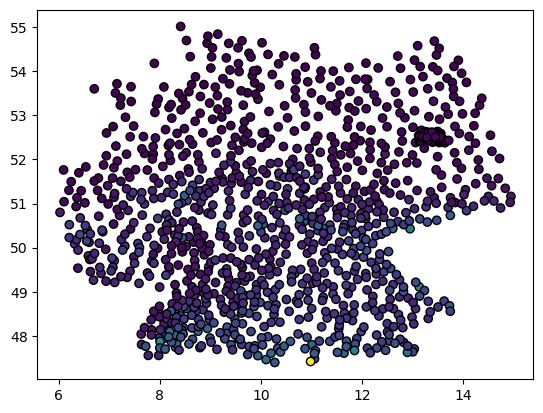

In [113]:
plt.scatter(df['geoLaenge'],df['geoBreite'], c= df["Stationshoehe"],  cmap="viridis", edgecolor="k")

In [114]:
df_10m = pd.read_csv('10min_processed.csv')
df_10m['date'] = pd.to_datetime(df_10m['date'] , format="%Y%m%d%H%M")
df_10m = df_10m[df_10m['rain'] != -999 ]

df_10m

,stationid,date,rain
0,6303,2024-04-20 00:00:00,0.0
1,6303,2024-04-20 00:10:00,0.0
2,6303,2024-04-20 00:20:00,0.0
3,6303,2024-04-20 00:30:00,0.0
4,6303,2024-04-20 00:40:00,0.0
...,...,...,...
150986,7429,2024-04-20 23:10:00,0.0
150987,7429,2024-04-20 23:20:00,0.0
150988,7429,2024-04-20 23:30:00,0.0
150989,7429,2024-04-20 23:40:00,0.0


In [115]:

#Aggregate and plot

df_10m["date"] = pd.to_datetime(df_10m["date"])

df_10m_agg = (
    df_10m
      .set_index("date")
      .groupby("stationid")
      .resample("h")
      ["rain"]
      .sum()
      .reset_index()
)


all_hours    = df_10m_agg["date"].unique()
all_stations = main_df["Stations_id"].unique()
full_index = pd.MultiIndex.from_product(
    [all_hours, all_stations],
    names=["date", "stationid"]
)

hourly = (
    df_10m_agg.set_index(["date", "stationid"])[["rain"]]
          .reindex(full_index, fill_value=0)
          .reset_index()
)


geo_cols = ["Stations_id", "geoBreite", "geoLaenge"]
hourly = hourly.merge(main_df[geo_cols],
                      left_on="stationid",
                      right_on="Stations_id",
                      how="left")



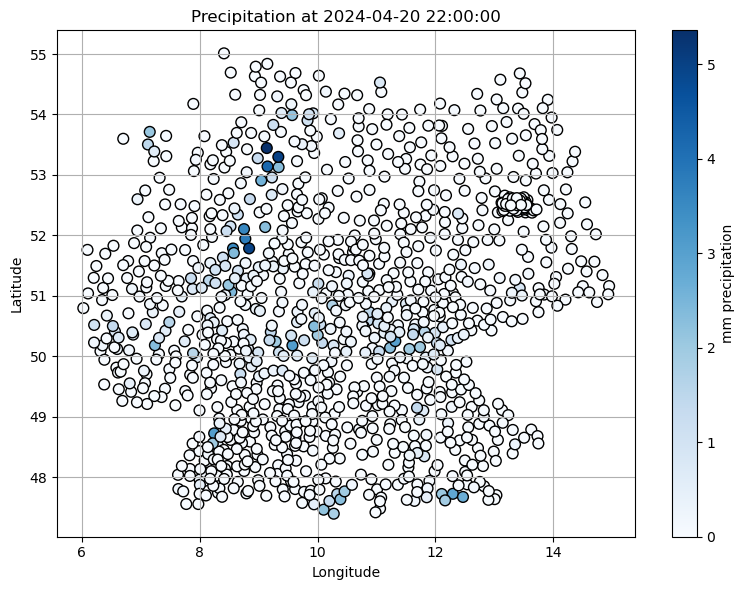

In [116]:
def plot_hour(ts, cmap="Blues"):
    """
    Scatterplot: all stations at the chosen hour.
    Colour = precipitation (mm).
    """
    hour   = pd.to_datetime(ts).floor("h")
    subset = hourly[hourly["date"] == hour]


    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        subset["geoLaenge"],
        subset["geoBreite"],
        c=subset["rain"],
        cmap=cmap,
        s=60,
        edgecolor="k"
    )
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label("mm precipitation")
    ax.set_title(f"Precipitation at {hour}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_hour("2024-04-20 22:00")

In [117]:

ts = "2024-04-20 22:00"                      # <— change to taste
ts = pd.to_datetime(ts).floor("H")
subset = hourly[hourly["date"] == ts]
subset


loaded  = np.load("griddata.npz")
geolat  = loaded["geolat"]
geolong = loaded["geolong"]
ind     = loaded["ind"]

grid_points = np.column_stack([geolong.ravel(), geolat.ravel()])
src_points = subset[["geoLaenge", "geoBreite"]].to_numpy()         # (M, 2)
src_values = subset["rain"].to_numpy()


interp = griddata(
    src_points, src_values,
    grid_points,
    method="linear"
).reshape(geolat.shape)

interp_masked = np.where(ind, interp, np.nan)

C:\Users\dadoi\AppData\Local\Temp\ipykernel_17128\3871035511.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = pd.to_datetime(ts).floor("H")


C:\Users\dadoi\AppData\Local\Temp\ipykernel_17128\1234188187.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(day, periods=24, freq="H")
C:\Users\dadoi\AppData\Local\Temp\ipykernel_17128\1234188187.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.86, 1])   # keep the colour-bar area free


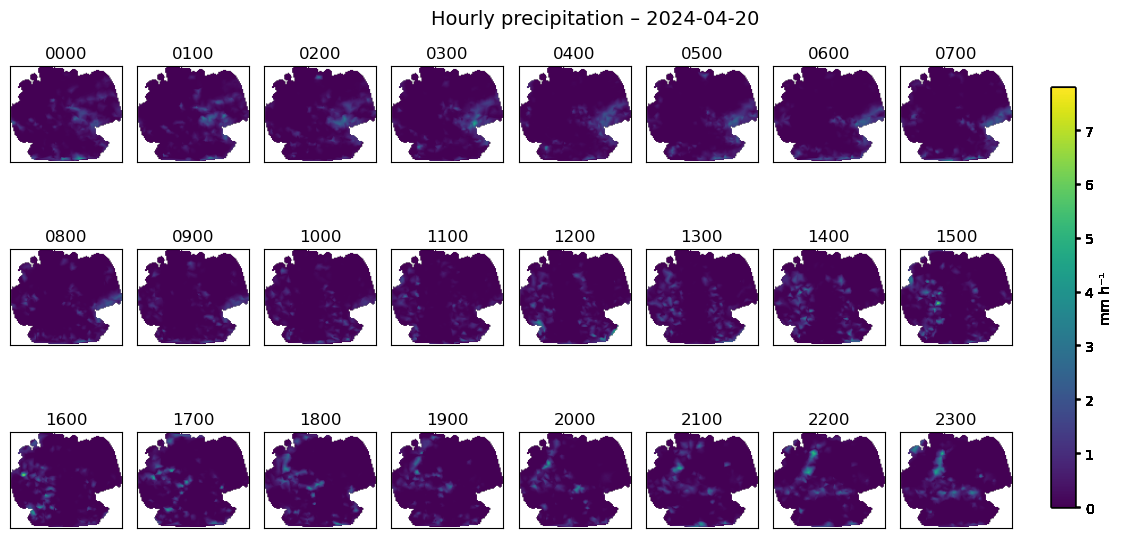

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd

def daily_precip_mosaic(day, hourly_df, geolong, geolat, ind,
                        method="linear", cmap="viridis",
                        n_cols=8, figsize=(12, 6)):
    """
    Make an 00-23 UTC mosaic of interpolated precipitation maps.

    Parameters
    ----------
    day        : str or datetime-like
        The calendar day to plot, e.g. "2024-04-20".
    hourly_df  : DataFrame
        Must have columns ["hour", "stationid", "rain", "geoBreite", "geoLaenge"].
    geolong,
    geolat     : 2-D arrays (same shape) of target grid coordinates.
    ind        : 2-D boolean array – True where interpolation is valid.
    method     : "linear", "cubic" or "nearest" → scipy.griddata method.
    cmap       : Matplotlib colormap name.
    n_cols     : Panels per row in the mosaic.
    figsize    : Overall figure size.
    """
    day = pd.to_datetime(day).normalize()
    hours = pd.date_range(day, periods=24, freq="H")
    src  = {h: hourly_df[hourly_df["date"] == h] for h in hours}

    vmax = max(s["rain"].max() if not s.empty else 0 for s in src.values())
    vmin = 0

    grid_pts = np.column_stack([geolong.ravel(), geolat.ravel()])

    n_rows = int(np.ceil(24 / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=figsize,
        subplot_kw=dict(aspect="equal", xticks=[], yticks=[])
    )
    axes = axes.ravel()

    #interpolation

    for i, h in enumerate(hours):
        ax  = axes[i]
        sub = src[h]


        vals = griddata(
            sub[["geoLaenge", "geoBreite"]].to_numpy(),
            sub["rain"].to_numpy(),
            grid_pts,
            method=method
        ).reshape(geolat.shape)

        vals = np.where(ind, vals, np.nan)

        im = ax.imshow(
            vals,
            extent=[geolong.min(), geolong.max(),
                    geolat.min(),  geolat.max()],
            origin="lower",
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        fig.subplots_adjust(right=0.86)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        fig.colorbar(im, cax=cbar_ax, label="mm h⁻¹")
        ax.set_title(h.strftime("%H%M"))

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 0.86, 1])   # keep the colour-bar area free
    fig.suptitle(f"Hourly precipitation – {day.date()}", y=0.98, fontsize=14)
    plt.show()


loaded = np.load("griddata.npz")
daily_precip_mosaic("2024-04-20", hourly,
                     loaded["geolong"], loaded["geolat"], loaded["ind"])
